In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd())) 

In [4]:
import pandas as pd
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, 
    log_loss, 
    brier_score_loss,
    roc_auc_score,
    classification_report
)
from sklearn.frozen import FrozenEstimator
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import OneHotEncoder
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Any
import logging
from dataclasses import dataclass, asdict
import pickle
import joblib
from datetime import datetime
import warnings

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.models import ModelSignature
from mlflow.types.schema import ColSpec, Schema

#import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA

from src.models.utils_models import (
    load_model_data, 
    data_split,
    transform_categorical_features
)
from src.models.model_classes import ModelConfig, TrainingResults
from src.gen_utils import load_config

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [10]:
class MLBModelTrainer: 
    """
    Production-ready MLB model trainer with calibration capabilities.
    
    Features: 
    - Time series cross-validation with proper data leakage prevention
    - Probability calibration (isotonic or sigmoid)
    - Comprehensive evaluation metrics
    - Calibration curve plotting
    - Model persistence
    - Logging and error handling
    """
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = None
        self.calibrated_model = None
        self.results = None
        self.feature_names = None
        self.is_trained = False
        self.one_hot_encoder = None # Stores fitted OneHotEncoder
        self.category_maps = None # Stores dictionary of {col: [categories]} for 'category' dtype
        self.numerical_feature_names = None # Stores names of numerical features
        self.all_final_feature_names = None # Stores the complete ordered list of all feature names after encoding

    def _validate_data(self, X: pd.DataFrame, y: pd.Series, groups: pd.Series) -> None:
        """Validate input data for training."""
        if X.empty or y.empty:
            raise ValueError("Training data cannot be empty")
        
        if (len(X) != len(y)) or (len(X) != len(groups)):
            raise ValueError("X, y, and groups must have the same length")
        
        if y.isnull().any():
            raise ValueError("Target variable contains null values")
        
        # Check for required categorical columns
        missing_cols = set(self.config.categorical_cols) - set(X.columns)
        if missing_cols: 
            raise ValueError(f"Missing required categorical columns: {missing_cols}")
        
    def _calculate_calibration_score(self, y_true: np.ndarray, y_prob: np.ndarray, n_bins: int = 10) -> float:
        """Calculate calibration score (reliability)"""
        try: 
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_true, y_prob, n_bins=n_bins, strategy="uniform"
            )
            # Calculate Expected Calibration Error (ECE)
            bin_boundaries = np.linspace(0,1,n_bins+1)
            bin_lowers = bin_boundaries[:-1]
            bin_uppers = bin_boundaries[1:]

            ece = 0
            for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
                in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
                prop_in_bin = in_bin.mean()

                if prop_in_bin > 0:
                    accuracy_in_bin = y_true[in_bin].mean()
                    avg_confidence_in_bin = y_prob[in_bin].mean()
                    ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
                
            return ece
        
        except Exception as e:
            logger.warning(f"Could not calculation calibration score: {e}")
            
            return np.nan
        
    def train_with_cross_validation(self, X: pd.DataFrame, y: pd.Series, groups: pd.Series) -> TrainingResults:
        """
        Train model with time series cross-validation and calibration.

        Parameters
        ----------
        X : pd.DataFrame
            Feature matrix
        y : pd.Series
            Target variable
        groups : pd.Series
            Time-based groups for cross-validation

        Returns
        -------
        TrainingResults
            Training results object with comprehensive metrics
        """
        # Data validation checks
        self._validate_data(X, y, groups)

        # Initialize cross-validation
        gts = GroupTimeSeriesSplit(**self.config.cv_params)

        # Initialize base model
        #base_model = cb.CatBoostClassifier(**self.config.hyperparams)
        base_model = LogisticRegression(**self.config.hyperparams)

        # Storage for results
        fold_results = {
            'accuracies': [],
            'log_losses': [],
            'brier_scores': [],
            'auc_scores': [],
            'calibration_scores': []
        }

        logger.info("Starting cross-validation training...")

        fold_num = 0
        for train_index, test_index in gts.split(X, y, groups=groups):
            fold_num += 1

            try: 
                # Extract training and testing sets for this fold
                X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
                y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

                # Get the unique dates for current train and test sets
                train_dates = groups.iloc[train_index].unique()
                test_dates = groups.iloc[test_index].unique()

                logger.info(f"Fold {fold_num}")
                logger.info(f"  Train samples: {len(X_train_fold)} | Test samples: {len(X_test_fold)}")
                logger.info(f"  Train dates: {len(train_dates)} ({train_dates.min()} to {train_dates.max()})")
                logger.info(f"  Test dates: {len(test_dates)} ({test_dates.min()} to {test_dates.max()})")

                # Verify no date overlap
                if len(train_dates) > 0 and len(test_dates) > 0:
                    if train_dates.max() >= test_dates.min():
                        logger.error(f"Date overlap detected! Train max: {train_dates.max()}, Test min: {test_dates.min()}")
                        raise ValueError("Date overlap detected in cross-validation split")
                    
                
                # --- Categorical Encoding for CV Fold ---
                # For CV, re-fit the encoder/category maps for each fold
                # to simulate a growing knowledge base over time.
                fold_numerical_cols = [col for col in X_train_fold if col not in self.config.categorical_cols]

                fold_one_hot_encoder = None
                fold_category_maps = None
                fold_all_final_cols = None

                if self.config.encoding_type == "one-hot":
                    fold_one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                    fold_one_hot_encoder.fit(X_train_fold[self.config.categorical_cols])
                    fold_encoded_cat_names = fold_one_hot_encoder.get_feature_names_out(self.config.categorical_cols)
                    fold_all_final_cols = fold_numerical_cols + list(fold_encoded_cat_names)
                elif self.config.encoding_type == "category":
                    fold_category_maps = {col: X_train_fold[col].unique().tolist() for col in self.config.categorical_cols}
                    fold_all_final_cols = fold_numerical_cols + self.config.categorical_cols

                X_train_encoded_fold = transform_categorical_features(
                    df=X_train_fold,
                    categorical_cols=self.config.categorical_cols,
                    encoding_type=self.config.encoding_type,
                    one_hot_encoder=fold_one_hot_encoder,
                    category_maps=fold_category_maps,
                    numerical_cols=fold_numerical_cols,
                    all_final_cols=fold_all_final_cols
                )

                X_test_encoded_fold = transform_categorical_features(
                    df=X_test_fold,
                    categorical_cols=self.config.categorical_cols,
                    encoding_type=self.config.encoding_type,
                    one_hot_encoder=fold_one_hot_encoder,
                    category_maps=fold_category_maps,
                    numerical_cols=fold_numerical_cols,
                    all_final_cols=fold_all_final_cols
                )
                # --- End Categorical Encoding for CV Fold ---

                # Store feature names from the *first* fold's processed training data.
                # These will be the definitive feature names for the final model and prediction.
                # Assumes consistent feature generation across folds based on configuration.
                if self.all_final_feature_names is None:
                    self.numerical_feature_names = fold_numerical_cols
                    self.all_final_feature_names = fold_all_final_cols
                    self.feature_names = fold_all_final_cols
                
                # Fit Logistic Regression
                base_model.fit(X_train_encoded_fold, y_train_fold)

                # Create calibrated classifier
                calibrated_model = CalibratedClassifierCV(
                    estimator=FrozenEstimator(base_model), 
                    method=self.config.calibration_method
                )
                
                # Train calibrated model
                calibrated_model.fit(X_train_encoded_fold, y_train_fold)

                # Make predictions
                y_pred = calibrated_model.predict(X_test_encoded_fold)
                y_pred_proba = calibrated_model.predict_proba(X_test_encoded_fold)[:, 1]

                # Calculate metrics
                accuracy = accuracy_score(y_test_fold, y_pred)
                log_loss_score = log_loss(y_test_fold, y_pred_proba)
                brier_score = brier_score_loss(y_test_fold, y_pred_proba)
                auc_score = roc_auc_score(y_test_fold, y_pred_proba)
                calibration_score = self._calculate_calibration_score(y_test_fold, y_pred_proba)

                # Store results
                fold_results['accuracies'].append(accuracy)
                fold_results['log_losses'].append(log_loss_score)
                fold_results['brier_scores'].append(brier_score)
                fold_results['auc_scores'].append(auc_score)
                fold_results['calibration_scores'].append(calibration_score)

                logger.info(f"  Accuracy: {accuracy: .4f}")
                logger.info(f"  Log Loss: {log_loss_score: .4f}")
                logger.info(f"  Brier Score: {brier_score: .4f}")
                logger.info(f"  AUC: {auc_score: .4f}")
                logger.info(f"  Calibration Score (ECE): {calibration_score: .4f}")

            except Exception as e:
                logger.error(f"Error in fold {fold_num} as e")
                raise 
        
        # Calculate summary statistics
        results = TrainingResults(
            fold_accuracies=fold_results['accuracies'],
            fold_log_losses=fold_results['log_losses'],
            fold_brier_scores=fold_results['brier_scores'],
            fold_auc_scores=fold_results['auc_scores'],
            calibration_scores=fold_results['calibration_scores'],
            mean_accuracy=np.mean(fold_results['accuracies']),
            std_accuracy=np.std(fold_results['accuracies']),
            mean_log_loss=np.mean(fold_results['log_losses']),
            mean_brier_score=np.mean(fold_results['brier_scores']),
            mean_auc=np.mean(fold_results['auc_scores']),
            mean_calibration_score=np.mean([s for s in fold_results['calibration_scores'] if not np.isnan(s)])
        )

        logger.info("\n" + "="*50)
        logger.info("CROSS-VALIDATION SUMMARY")
        logger.info("="*50)
        logger.info(f"Mean Accuracy: {results.mean_accuracy: .4f} (+/-{results.std_accuracy: .4f})")
        logger.info(f"Mean Log Loss: {results.mean_log_loss:.4f}")
        logger.info(f"Mean Brier Score: {results.mean_brier_score:.4f}")
        logger.info(f"Mean AUC: {results.mean_auc:.4f}")
        logger.info(f"Mean Calibration Score (ECE): {results.mean_calibration_score:.4f}")

        self.results = results

        return results
    
    def train_final_model(self, X: pd.DataFrame, y: pd.Series) -> None:
        """Train the final model on all available data"""
        logger.info("Training final calibrated model on all data...")

        # Store numerical feature names
        self.numerical_feature_names = [col for col in X.columns if col not in self.config.categorical_cols]

        # Fit and store the appropriate encoder/category maps based on encoding_type
        if self.config.encoding_type == "one-hot":
            self.one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            self.one_hot_encoder.fit(X[self.config.categorical_cols])
            encoded_cat_names = self.one_hot_encoder.get_feature_names_out(self.config.categorical_cols)
            self.all_final_feature_names = self.numerical_feature_names + list(encoded_cat_names)
        elif self.config.encoding_type == "category":
            self.category_maps = {col: X[col].unique().tolist() for col in self.config.categorical_cols}
            self.all_final_feature_names = self.numerical_feature_names + self.config.categorical_cols
        else:
            raise ValueError(f"Unsupported encoding_type: {self.config.encoding_type}")
        
        # Transform the full training data using the newly fitted encoder/maps
        X_encoded  = transform_categorical_features(
            df=X,
            categorical_cols=self.config.categorical_cols,
            encoding_type=self.config.encoding_type,
            one_hot_encoder=self.one_hot_encoder,
            category_maps=self.category_maps,
            numerical_cols=self.numerical_feature_names,
            all_final_cols=self.all_final_feature_names
        )

        # Assign the final feature names to self.feature_names for model saving/loading consistency
        self.feature_names = self.all_final_feature_names

        # Create and train final model
        base_model = LogisticRegression(**self.config.hyperparams)
        #base_model = self._get_lgbm_model()
        base_model.fit(X_encoded, y)

        # Store base model to extract feature importance
        self.model = base_model

        self.calibrated_model = CalibratedClassifierCV(
            estimator=FrozenEstimator(base_model),
            method=self.config.calibration_method
        )

        self.calibrated_model.fit(X_encoded, y)
        self.is_trained = True

        logger.info("Final model training completed")

    def _get_transformed_data(self, X_raw: pd.DataFrame) -> pd.DataFrame:
        """Helper method to transform raw input data using the stored encoder/category maps"""
        if self.all_final_feature_names is None or self.numerical_feature_names is None:
            raise ValueError("Model not fully trained or feature names not set. Call train_final_model first.")
        
        # Pass the correct encoder/map based on ecoding_type
        return transform_categorical_features(
            df=X_raw,
            categorical_cols=self.config.categorical_cols,
            encoding_type=self.config.encoding_type,
            one_hot_encoder=self.one_hot_encoder, # Will be None if encoding_type is 'category'
            category_maps=self.category_maps, # Will be None if encoding_type is 'one-hot'
            numerical_cols=self.numerical_feature_names,
            all_final_cols=self.all_final_feature_names
        )
    
    def plot_calibration_curve(self, X: pd.DataFrame, y: pd.Series, save_path: Optional[str] = None) -> None:
        """Plot calibration curve for the trained model"""
        if not self.is_trained:
            raise ValueError("Model must be trained before plotting calibration curve")
        
        # Use the helper method to transform the data for plotting
        X_encoded = self._get_transformed_data(X)
        #X_encoded = X.copy()

        # Get probabilities
        y_pred_proba = self.calibrated_model.predict_proba(X_encoded)[:, 1]

        # Creat calibration curve
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y, y_pred_proba, n_bins=10, strategy='quantile'
        )

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(14,6))

        # Calibration Curve
        axes[0].plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibrated CatBoost")
        axes[0].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        axes[0].set_xlabel("Mean Predicted Probability")
        axes[0].set_ylabel("Fraction of Positives")
        axes[0].set_title("Calibration Curve | strategy = 'quantile'")
        axes[0].legend()
        axes[0].grid(True)
        
        # Histogram of probabilities
        axes[1].hist(y_pred_proba, bins=20, alpha=0.7, edgecolor='black')
        axes[1].set_xlabel("Predicted Probability")
        axes[1].set_ylabel("Count")
        axes[1].set_title("Distribution of Predicted Probabilities")
        axes[1].grid(True)
        
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Calibration of Predicted Probabilities")
            mlflow.log_artifact(save_path)
        
        plt.close(fig)

    def plot_feature_importance(self, save_path: Optional[str] = None, top_n: int=20) -> None:
        """Plot feature importance for base CatBoost model"""
        if not self.is_trained or self.model is None:
            raise ValueError("Base model not trained. Call train_final_model first.")
        
        if not hasattr(self.model, 'coef_'):
            logger.warning("Base model does not have coef_ attribute. Cannot plot importance.")
            return 
        
        importances = self.model.coef_[0]
        #feature_names = self.feature_names
        feature_names = self.model.feature_names_in_
        print("Importances...")
        print(len(importances))
        print("Features...")
        print(len(feature_names))

        if feature_names is None or len(feature_names) != len(importances):
            logger.warning("Feature names not available or mismatch with importances. Cannot plot importance.")
            return 
        
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)

        plt.figure(figsize=(10,8))
        sns.barplot(x='importance',y='feature', data=feature_importance_df.head(top_n))
        plt.title(f"Top {top_n} Feature Importances")
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Feature importance plot saved to {save_path}")
            mlflow.log_artifact(save_path)
        plt.close()

    def save_model(self, file_path: str) -> None: 
        """Save the trained model and configuration"""
        if not self.is_trained:
            raise ValueError("Model must be trained before saving")
        
        model_data = {
            'model': self.calibrated_model,
            'config': self.config,
            'results': self.results,
            'feature_names': self.feature_names,
            'one_hot_encoder': self.one_hot_encoder,
            'category_maps': self.category_maps,
            'numerical_feature_names': self.numerical_feature_names,
            'all_final_feature_names': self.all_final_feature_names,
            'training_timestamp': datetime.now().isoformat()
        }

        joblib.dump(model_data, file_path)
        logger.info(f"Model saved to {file_path}")

    @classmethod
    def load_models(cls, file_path: str) -> 'MLBModelTrainer':
        """Load a saved model"""
        model_data = joblib.load(file_path)

        trainer = cls(model_data['config'])
        trainer.calibrated_model = model_data['model']
        trainer.results = model_data['results']
        trainer.feature_names = model_data['feature_names']
        trainer.one_hot_encoder = model_data['one_hot_encoder']
        trainer.category_maps = model_data['category_maps']
        trainer.numerical_feature_names = model_data['numerical_feature_names']
        trainer.all_final_feature_names = model_data['all_final_feature_names']
        trainer.is_trained = True

        logger.info(f"Model loaded from {file_path}")

        return trainer
    
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """Make predictions with the trained model"""
        if not self.is_trained: 
            raise ValueError("Model must be trained before making predictions")
        
        X_encoded = self._get_transformed_data(X)
        #X_encoded = X.copy()

        return self.calibrated_model.predict(X_encoded)
    
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        """Make predictions with the trained model"""
        if not self.is_trained: 
            raise ValueError("Model must be trained before making predictions")
        
        X_encoded = self._get_transformed_data(X)
        #X_encoded = X.copy()

        return self.calibrated_model.predict_proba(X_encoded)
    

    

In [74]:
def pca_dim_reduc(X_scaled, cols, n_components): 
    pca = PCA(n_components=n_components)
    pca_ = pca.fit(X_scaled[cols])
    print(f"Explained Variance Ratio CumSum: {pca_.explained_variance_ratio_.cumsum()}") 
    return pd.DataFrame(pca.transform(X_scaled[cols])), pca_

In [100]:
# Definitions
logger.info(f"MLflow Run ID: {run.info.run_id}")
# Load data
input_model_data = "../data/processed/model_data.csv"
df_model = load_model_data(input_model_data)
df_model  = df_model[df_model['game_date']<datetime.today()]
target = 'home_win'
holdout_start_date = '2025-05-15'
# Data splitting
df_train_init, df_holdout, _ = data_split(
    df=df_model,
    holdout_start_date=holdout_start_date,
    group_col='game_date'
)

# Separate columns
cols_to_remove = [target, 'game_id','game_date','game_date_time',
                  'home_team_id','away_team_id', 'state', 'game_type', 
                  'home_score','away_score'
]
cat_cols = ['home_team','away_team','venue']
num_cols = list((set(df_train_init.columns)-set(cols_to_remove))-set(cat_cols))

# Standardize with regularized logistic regression
X_train_init_num = df_train_init[num_cols]
X_train_init_cat = df_train_init[cat_cols]
scalar = StandardScaler() 
X_train_init_scaled = pd.DataFrame(scalar.fit_transform(X_train_init_num), columns=num_cols) 

pitch_cols = list(df_train_init.columns[df_train_init.columns.str.contains('pitch|era|whip')])
run_cols = list(df_train_init.columns[df_train_init.columns.str.contains('run')])
hit_cols = list(df_train_init.columns[df_train_init.columns.str.contains('obp|slg')])
sched_cols = list(df_train_init.columns[df_train_init.columns.str.contains('games|rest|back2back|season')])
win_cols = list(df_train_init.columns[df_train_init.columns.str.contains('win_rate')])

X_train_init_pitch_pca, pca_pitch = pca_dim_reduc(X_train_init_scaled, cols=pitch_cols, n_components=.9)
X_train_init_run_pca, pca_run = pca_dim_reduc(X_train_init_scaled, cols=run_cols, n_components=.9)
X_train_init_hit_pca, pca_hit = pca_dim_reduc(X_train_init_scaled, cols=hit_cols, n_components=.9)
X_train_init_sched_pca, pca_sched = pca_dim_reduc(X_train_init_scaled, cols=sched_cols, n_components=.9)
X_train_init_win_pca, pca_win = pca_dim_reduc(X_train_init_scaled, cols=win_cols, n_components=.9)

X_train_init_pca = pd.concat([X_train_init_pitch_pca, X_train_init_run_pca, X_train_init_hit_pca, X_train_init_sched_pca, X_train_init_win_pca], axis=1) 
X_train_init_pca.columns = [f'PC_{i}' for i in range(X_train_init_pca.shape[1])]

X_holdout_num = df_holdout[num_cols]
X_holdout_scaled = pd.DataFrame(scalar.transform(X_holdout_num), columns=num_cols).reset_index()
X_holdout_cat = df_holdout[cat_cols].reset_index()

X_holdout_pitch_pca = pd.DataFrame(pca_pitch.transform(X_holdout_scaled[pitch_cols].copy()))
X_holdout_run_pca = pd.DataFrame(pca_run.transform(X_holdout_scaled[run_cols].copy()))
X_holdout_hit_pca = pd.DataFrame(pca_hit.transform(X_holdout_scaled[hit_cols].copy()))
X_holdout_sched_pca = pd.DataFrame(pca_sched.transform(X_holdout_scaled[sched_cols].copy()))
X_holdout_win_pca = pd.DataFrame(pca_win.transform(X_holdout_scaled[win_cols].copy()))

X_holdout_pca = pd.concat([X_holdout_pitch_pca, X_holdout_run_pca, X_holdout_hit_pca, X_holdout_sched_pca, X_holdout_win_pca], axis=1)
X_holdout_pca.columns = [f'PC_{i}' for i in range(X_holdout_pca.shape[1])]

X_train_init = pd.concat([X_train_init_pca, X_train_init_cat], axis=1)
X_holdout = pd.concat([X_holdout_pca, X_holdout_cat], axis=1)

# Prepare features (X) and target (y) for training and holdout
#X_train_init = df_train_init.drop(cols_to_remove, axis=1)
#feature_subset = ['home_team_games_prev_7days', 'home_team_season_opener_flag','home_team_rest_days','away_team']
#X_train_init = X_train_init[feature_subset]
y_train_init = df_train_init[target]

#X_holdout = df_holdout.drop(cols_to_remove, axis=1)
#X_holdout = X_holdout[feature_subset]
y_holdout = df_holdout[target]

# Define groups for GroupTSCV - do i not need groups from data_split() ? --> will groups for holdout be useful?
groups = df_train_init['game_date']



# Configuration
config = ModelConfig(
    model_type="logistic-scaled",
    hyperparams={
        'penalty': 'l1',
        'C': .005,
        'solver': 'liblinear'
    },
    cv_params={
        'test_size': 30,
        #'train_size': 360,
        'n_splits': 100, # for testing purposes
        'gap_size': 3,
        'window_type': 'rolling'
    },
    categorical_cols=cat_cols,
    encoding_type='one-hot',
    calibration_method='sigmoid',
    random_state=888,
    holdout_start_date=holdout_start_date
)

INFO:__main__:MLflow Run ID: 60db19bf73314e07875bbe7fc94de85c


Explained Variance Ratio CumSum: [0.14582094 0.2747064  0.37687361 0.43229052 0.47246504 0.5089571
 0.54244343 0.57391834 0.6031539  0.62898447 0.6523446  0.67276554
 0.69239983 0.70892726 0.72497587 0.73975387 0.75381244 0.76553619
 0.7769026  0.78720917 0.79738317 0.80729641 0.81699406 0.82635196
 0.83507752 0.84373886 0.85172266 0.85943768 0.86712816 0.87468665
 0.88207744 0.88874076 0.89527142 0.90161846]
Explained Variance Ratio CumSum: [0.26461418 0.49716257 0.65242275 0.77787774 0.84766177 0.89938339
 0.93415877]
Explained Variance Ratio CumSum: [0.29551356 0.4707413  0.61304512 0.73207727 0.80457877 0.84931005
 0.88380043 0.91208323]
Explained Variance Ratio CumSum: [0.4032964  0.65532891 0.81628013 0.9264341 ]
Explained Variance Ratio CumSum: [0.59236593 1.        ]


In [76]:
X_train_init.shape, X_holdout.shape

((10160, 58), (837, 59))

In [101]:
# Train model
trainer = MLBModelTrainer(config)

# Cross-validation
results = trainer.train_with_cross_validation(X_train_init, y_train_init, groups)

INFO:__main__:Starting cross-validation training...
INFO:__main__:Fold 1
INFO:__main__:  Train samples: 8452 | Test samples: 400
INFO:__main__:  Train dates: 646 (2021-04-01 00:00:00 to 2024-07-06 00:00:00)
INFO:__main__:  Test dates: 30 (2024-07-10 00:00:00 to 2024-08-12 00:00:00)
INFO:__main__:  Accuracy:  0.4975
INFO:__main__:  Log Loss:  0.6927
INFO:__main__:  Brier Score:  0.2498
INFO:__main__:  AUC:  0.5284
INFO:__main__:  Calibration Score (ECE):  0.0475
INFO:__main__:Fold 2
INFO:__main__:  Train samples: 8454 | Test samples: 400
INFO:__main__:  Train dates: 646 (2021-04-02 00:00:00 to 2024-07-07 00:00:00)
INFO:__main__:  Test dates: 30 (2024-07-11 00:00:00 to 2024-08-13 00:00:00)
INFO:__main__:  Accuracy:  0.4975
INFO:__main__:  Log Loss:  0.6916
INFO:__main__:  Brier Score:  0.2493
INFO:__main__:  AUC:  0.5367
INFO:__main__:  Calibration Score (ECE):  0.0495
INFO:__main__:Fold 3
INFO:__main__:  Train samples: 8455 | Test samples: 403
INFO:__main__:  Train dates: 646 (2021-04-0

In [103]:
# Train final model
trainer.train_final_model(X_train_init, y_train_init)

INFO:__main__:Training final calibrated model on all data...
INFO:__main__:Final model training completed


In [96]:
print(f"Mean ACC: {float(np.mean(trainer.results.fold_accuracies))}")
print(f"STD ACC: {float(np.std(trainer.results.fold_accuracies))}")

Mean ACC: 0.5456960259470688
STD ACC: 0.002345960700115061


In [85]:
trainer.plot_calibration_curve(X_train_init, y_train_init, save_path='../src/figures/calibration_curve_train_logistic_scaled.png')

INFO:__main__:Calibration of Predicted Probabilities


In [86]:
trainer.plot_calibration_curve(X_holdout, y_holdout, save_path='../src/figures/calibration_curve_holdout_logistic_scaled.png')

INFO:__main__:Calibration of Predicted Probabilities


In [87]:
# Plot feature importances
trainer.plot_feature_importance(save_path='../src/figures/feature_importances_logistic_scaled.png', top_n = 20)

Importances...
160
Features...
160


INFO:__main__:Feature importance plot saved to ../src/figures/feature_importances_logistic_scaled.png


In [104]:
# Evaluate on holdout set
holdout_predictions = trainer.predict(X_holdout)
holdout_probabilities = trainer.predict_proba(X_holdout)[:, 1]

holdout_accuracy = accuracy_score(y_holdout, holdout_predictions)
holdout_log_loss = log_loss(y_holdout, holdout_probabilities)
holdout_brier = brier_score_loss(y_holdout, holdout_probabilities)
holdout_auc = roc_auc_score(y_holdout, holdout_probabilities)

logger.info("\n" + "="*50)
logger.info("HOLDOUT SET EVALUTION")
logger.info("="*50)
logger.info(f"Holdout Accuracy: {holdout_accuracy: .4f}")
logger.info(f"Holdout Log Loss: {holdout_log_loss: .4f}")
logger.info(f"Holdout Brier Score: {holdout_brier: .4f}")
logger.info(f"Holdout AUC: {holdout_auc: .4f}")

INFO:__main__:
INFO:__main__:HOLDOUT SET EVALUTION
INFO:__main__:==================================================
INFO:__main__:Holdout Accuracy:  0.5424
INFO:__main__:Holdout Log Loss:  0.6823
INFO:__main__:Holdout Brier Score:  0.2447
INFO:__main__:Holdout AUC:  0.5651


INFO:__main__:MLflow Run ID: 60db19bf73314e07875bbe7fc94de85c
INFO:__main__:Starting cross-validation training...
INFO:__main__:Fold 1
INFO:__main__:  Train samples: 4723 | Test samples: 396
INFO:__main__:  Train dates: 360 (2021-04-01 00:00:00 to 2022-10-04 00:00:00)
INFO:__main__:  Test dates: 30 (2023-04-01 00:00:00 to 2023-04-30 00:00:00)
INFO:__main__:  Accuracy:  0.5556
INFO:__main__:  Log Loss:  0.7771
INFO:__main__:  Brier Score:  0.2493
INFO:__main__:  AUC:  0.5748
INFO:__main__:  Calibration Score (ECE):  0.0457
INFO:__main__:Fold 2
INFO:__main__:  Train samples: 4725 | Test samples: 388
INFO:__main__:  Train dates: 360 (2021-04-02 00:00:00 to 2022-10-05 00:00:00)
INFO:__main__:  Test dates: 30 (2023-04-02 00:00:00 to 2023-05-01 00:00:00)
INFO:__main__:  Accuracy:  0.5619
INFO:__main__:  Log Loss:  0.7757
INFO:__main__:  Brier Score:  0.2476
INFO:__main__:  AUC:  0.5858
INFO:__main__:  Calibration Score (ECE):  0.0421
INFO:__main__:Fold 3
INFO:__main__:  Train samples: 4734 |

FileNotFoundError: [Errno 2] No such file or directory: 'src/figures/calibration_curve_train_logistic_scaled.png'

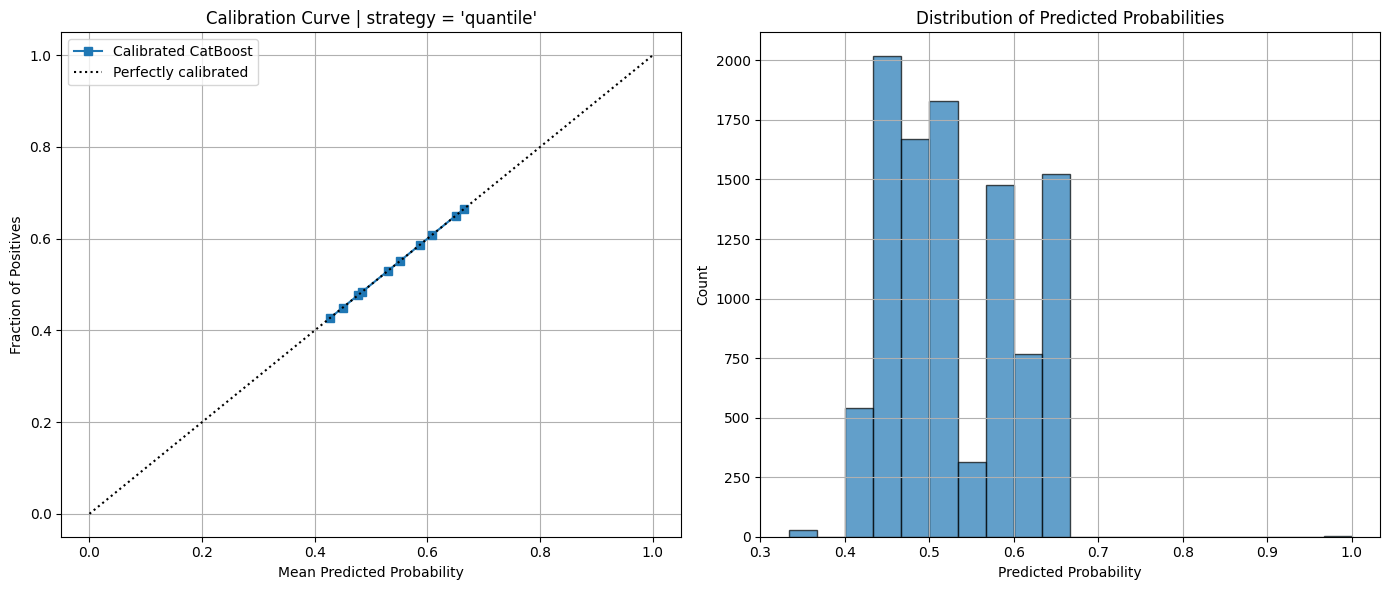

In [9]:
# Start MLflow run
mlflow.set_experiment("MLB_Betting_Model_Training")
with mlflow.start_run() as run:
    logger.info(f"MLflow Run ID: {run.info.run_id}")
    # Load data
    input_model_data = "../data/processed/model_data.csv"
    df_model = load_model_data(input_model_data)
    df_model  = df_model[df_model['game_date']<datetime.today()]
    target = 'home_win'
    holdout_start_date = '2025-05-15'
    # Data splitting
    df_train_init, df_holdout, _ = data_split(
        df=df_model,
        holdout_start_date=holdout_start_date,
        group_col='game_date'
    )

    # Separate columns
    cols_to_remove = [target, 'game_id','game_date','game_date_time',
                      'home_team_id','away_team_id', 'state', 'game_type', 
                      'home_score','away_score'
    ]
    cat_cols = ['home_team','away_team','venue']
    num_cols = list((set(df_train_init.columns)-set(cols_to_remove))-set(cat_cols))

    # Standardize with regularized logistic regression
    X_train_init_num = df_train_init[num_cols]
    X_train_init_cat = df_train_init[cat_cols]
    scalar = StandardScaler() 
    X_train_init_scaled = pd.DataFrame(scalar.fit_transform(X_train_init_num), columns=num_cols) 

    X_holdout_num = df_holdout[num_cols]
    X_holdout_scaled = pd.DataFrame(scalar.transform(X_holdout_num), columns=num_cols)
    X_holdout_cat = df_holdout[cat_cols]

    X_train_init = pd.concat([X_train_init_scaled, X_train_init_cat], axis=1)
    X_holdout = pd.concat([X_holdout_scaled, X_holdout_cat], axis=1)

    # Prepare features (X) and target (y) for training and holdout
    #X_train_init = df_train_init.drop(cols_to_remove, axis=1)
    #feature_subset = ['home_team_games_prev_7days', 'home_team_season_opener_flag','home_team_rest_days','away_team']
    #X_train_init = X_train_init[feature_subset]
    y_train_init = df_train_init[target]

    #X_holdout = df_holdout.drop(cols_to_remove, axis=1)
    #X_holdout = X_holdout[feature_subset]
    y_holdout = df_holdout[target]

    # Define groups for GroupTSCV - do i not need groups from data_split() ? --> will groups for holdout be useful?
    groups = df_train_init['game_date']

    

    # Configuration
    config = ModelConfig(
        model_type="logistic-scaled",
        hyperparams={
            'penalty': 'l1',
            'C': .005,
            'solver': 'liblinear'
        },
        cv_params={
            'test_size': 30,
            'train_size': 360,
            #'n_splits': 3, # for testing purposes
            'gap_size': 3,
            'window_type': 'rolling'
        },
        categorical_cols=cat_cols,
        encoding_type='one-hot',
        calibration_method='isotonic',
        random_state=888,
        holdout_start_date=holdout_start_date
    )

    # Log ModelConfig parameters
    mlflow.log_param("model_type", config.model_type)
    mlflow.log_params(config.hyperparams)
    mlflow.log_params(config.cv_params)
    mlflow.log_param("categorical_cols", config.categorical_cols)
    mlflow.log_param("encoding_type", config.encoding_type)
    mlflow.log_param("calibration_method", config.calibration_method)
    mlflow.log_param("random_state", config.random_state)
    mlflow.log_param("holdout_start_date", config.holdout_start_date)

    # Train model
    trainer = MLBModelTrainer(config)

    # Cross-validation
    results = trainer.train_with_cross_validation(X_train_init, y_train_init, groups)

    mlflow.log_metric("cv_mean_accuracy", results.mean_accuracy)
    mlflow.log_metric("cv_mean_log_loss", results.mean_log_loss)
    mlflow.log_metric("cv_mean_brier_score", results.mean_brier_score)
    mlflow.log_metric("cv_mean_auc", results.mean_auc)
    mlflow.log_metric("cv_mean_calibration_score", results.mean_calibration_score)

    # Train final model
    trainer.train_final_model(X_train_init, y_train_init)

    # Plot calibration curve
    trainer.plot_calibration_curve(X_train_init, y_train_init, save_path='src/figures/calibration_curve_train_logistic_scaled.png')
    trainer.plot_calibration_curve(X_holdout, y_holdout, save_path='src/figures/calibration_curve_holdout_logistic_scaled.png')

    # Plot feature importances
    trainer.plot_feature_importance(save_path='src/figures/feature_importances_logistic_scaled.png', top_n = 20)

    # Save model
    trainer.save_model('src/saved_models/trained_mlb_model_logistic_scaled.pkl')

    # Log the trained CalibratedClassifierCV model
    mlflow.sklearn.log_model(
        sk_model=trainer.calibrated_model,
        name="mlb_model_logistic_scaled",
        registered_model_name="MLB_Calibrated_Logistic_Scaled_Model",
    )

    # Evaluate on holdout set
    holdout_predictions = trainer.predict(X_holdout)
    holdout_probabilities = trainer.predict_proba(X_holdout)[:, 1]

    holdout_accuracy = accuracy_score(y_holdout, holdout_predictions)
    holdout_log_loss = log_loss(y_holdout, holdout_probabilities)
    holdout_brier = brier_score_loss(y_holdout, holdout_probabilities)
    holdout_auc = roc_auc_score(y_holdout, holdout_probabilities)

    logger.info("\n" + "="*50)
    logger.info("HOLDOUT SET EVALUTION")
    logger.info("="*50)
    logger.info(f"Holdout Accuracy: {holdout_accuracy: .4f}")
    logger.info(f"Holdout Log Loss: {holdout_log_loss: .4f}")
    logger.info(f"Holdout Brier Score: {holdout_brier: .4f}")
    logger.info(f"Holdout AUC: {holdout_auc: .4f}")

    mlflow.log_metric("holdout_accuracy", holdout_accuracy)
    mlflow.log_metric("holdout_log_loss", holdout_log_loss)
    mlflow.log_metric("holdout_brier_score", holdout_brier)
    mlflow.log_metric("holdout_auc", holdout_auc)

logger.info("MLflow run finished.")